# 画像からポケモンの種族値を予測

In [0]:
import numpy as np
import pandas as pd
import glob
import cv2
import pathlib
import os
import sys
import PIL

%matplotlib inline
import matplotlib.pyplot as plt

## データ読み込み
ポケモンの画像と種族値のデータを用意する

### Pokemon- Weedle's Cave
https://www.kaggle.com/vishalsubbiah/pokemon-images-and-types

ポケモンの画像データ



In [0]:
# アップロードしたZipファイルの解凍
!unzip images.zip

In [3]:
df_pokeimg = pd.read_csv('pokemon_images.csv')
df_pokeimg

,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,NaN
4,charmeleon,Fire,NaN
...,...,...,...
804,stakataka,Rock,Steel
805,blacephalon,Fire,Ghost
806,zeraora,Electric,NaN
807,meltan,Steel,NaN


### Pokemon Sun and Moon (Gen 7) Stats

https://www.kaggle.com/mylesoneill/pokemon-sun-and-moon-gen-7-stats

ポケモンの種族値等のデータ

In [4]:
df_poke = pd.read_csv('pokemon.csv')

# ポケモンの名前を小文字に
strlow = lambda x: str(x).lower()
df_poke['species'] = df_poke['species'].map(strlow)

df_poke

,id,ndex,species,forme,type1,type2,ability1,ability2,abilityH,hp,attack,defense,spattack,spdefense,speed,total,weight,height,dex1,dex2,class,percent-male,percent-female,pre-evolution,egg-group1,egg-group2
0,1,1,bulbasaur,Bulbasaur,Grass,Poison,Overgrow,NaN,Chlorophyll,45,49,49,65,65,45,318,15.2 lbs.,"2'04""",NaN,NaN,Seed Pokémon,0.875,0.125,NaN,Monster,Grass
1,2,2,ivysaur,Ivysaur,Grass,Poison,Overgrow,NaN,Chlorophyll,60,62,63,80,80,60,405,28.7 lbs.,"3'03""",NaN,NaN,Seed Pokémon,0.875,0.125,Bulbasaur,Monster,Grass
2,3,3,venusaur,Venusaur,Grass,Poison,Overgrow,NaN,Chlorophyll,80,82,83,100,100,80,525,220.5 lbs.,"6'07""",NaN,NaN,Seed Pokémon,0.875,0.125,Ivysaur,Monster,Grass
3,4,4,charmander,Charmander,Fire,NaN,Blaze,NaN,Solar Power,39,52,43,60,50,65,309,18.7 lbs.,"2'00""",NaN,NaN,Lizard Pokémon,0.875,0.125,NaN,Monster,Dragon
4,5,5,charmeleon,Charmeleon,Fire,NaN,Blaze,NaN,Solar Power,58,64,58,80,65,80,405,41.9 lbs.,"3'07""",NaN,NaN,Flame Pokémon,0.875,0.125,Charmander,Monster,Dragon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1056,1058,778,mimikyu,Mimikyu (Busted Form),Ghost,Fairy,Disguise,Disguise,Disguise,60,100,60,100,60,120,500,1.5 lbs.,"0'08""",After going to all the effort of disguising it...,If its neck is broken or its rag torn during a...,Disguise Pokémon,0.500,0.500,NaN,Amorphous,NaN
1057,1059,778,mimikyu,Mimikyu (2),Ghost,Fairy,Disguise,Disguise,Disguise,60,100,60,100,60,120,500,1.5 lbs.,"0'08""",NaN,NaN,Disguise Pokémon,0.500,0.500,NaN,Amorphous,NaN
1058,1060,778,mimikyu,Mimikyu (3),Ghost,Fairy,Disguise,Disguise,Disguise,60,100,60,100,60,120,500,1.5 lbs.,"0'08""",NaN,NaN,Disguise Pokémon,0.500,0.500,NaN,Amorphous,NaN
1059,1061,784,kommo-o,Kommo-o (1),Dragon,Fighting,Bulletproof,Soundproof,Overcoat,75,110,125,100,105,85,600,172.4 lbs.,"5'03""",NaN,NaN,Scaly Pokémon,0.500,0.500,NaN,Dragon,NaN


## 前処理
第６世代までを訓練データ、第７世代を評価データとして使う

### 出力の種族値データを作成

In [0]:
# ２つのデータのCSVを紐付け
def isExistsLowNum(name):
  try:
    # 複数フォームあるデータについては1つ目のインデックス値を返す
    return df_poke.query('species == "' + name + '"').index[0]
  except:
    return np.nan

In [6]:
df_pokeimg['id'] = df_pokeimg['Name'].map(isExistsLowNum)
df_pokeimg.head()

,Name,Type1,Type2,id
0,bulbasaur,Grass,Poison,0.0
1,ivysaur,Grass,Poison,1.0
2,venusaur,Grass,Poison,2.0
3,charmander,Fire,NaN,3.0
4,charmeleon,Fire,NaN,4.0


In [7]:
df_pokeimg['id'].isnull().sum()

39

In [8]:
df_pokeimg[df_pokeimg['id'].isnull()]

,Name,Type1,Type2,id
28,nidoran-f,Poison,NaN,NaN
31,nidoran-m,Poison,NaN,NaN
82,farfetchd,Normal,Flying,NaN
121,mr-mime,Psychic,Fairy,NaN
385,deoxys-normal,Psychic,NaN,NaN
412,wormadam-plant,Bug,Grass,NaN
438,mime-jr,Psychic,Fairy,NaN
486,giratina-altered,Ghost,Dragon,NaN
491,shaymin-land,Grass,NaN,NaN
549,basculin-red-striped,Water,NaN,NaN


#### ポケモンの名前がデータ間で異なる場合は名寄せ

In [0]:
df_poke.iloc[28, 2] = 'nidoran-f'
df_poke.iloc[31, 2] = 'nidoran-m'
df_poke.iloc[82, 2] = 'farfetchd'
df_poke.iloc[121, 2] = 'mr-mime'
df_poke.iloc[385, 2] = 'deoxys-normal'
df_poke.iloc[412, 2] = 'wormadam-plant'
df_poke.iloc[438, 2] = 'mime-jr'
df_poke.iloc[486, 2] = 'giratina-altered'
df_poke.iloc[491, 2] = 'shaymin-land'
df_poke.iloc[549, 2] = 'basculin-red-striped'
df_poke.iloc[554, 2] = 'darmanitan-standard'
df_poke.iloc[640, 2] = 'tornadus-incarnate'
df_poke.iloc[641, 2] = 'thundurus-incarnate'
df_poke.iloc[644, 2] = 'landorus-incarnate'
df_poke.iloc[646, 2] = 'keldeo-ordinary'
df_poke.iloc[647, 2] = 'meloetta-aria'
df_poke.iloc[668, 2] = 'flabebe'
df_poke.iloc[677, 2] = 'meowstic-male'
df_poke.iloc[680, 2] = 'aegislash-blade'
df_poke.iloc[709, 2] = 'pumpkaboo-average'
df_poke.iloc[710, 2] = 'gourgeist-average'
df_poke.iloc[717, 2] = 'zygarde-50'
df_poke.iloc[719, 2] = 'hoopa-confined'
df_poke.iloc[740, 2] = 'oricorio-baile'
df_poke.iloc[744, 2] = 'lycanroc-midday'
df_poke.iloc[745, 2] = 'wishiwashi-solo'
df_poke.iloc[771, 2] = 'type-null'
df_poke.iloc[773, 2] = 'minior-meteor'
df_poke.iloc[784, 2] = 'tapu-koko'
df_poke.iloc[785, 2] = 'tapu-lele'
df_poke.iloc[786, 2] = 'tapu-bulu'
df_poke.iloc[787, 2] = 'tapu-fini'

In [0]:
df_pokeimg['id'] = df_pokeimg['Name'].map(isExistsLowNum)

In [11]:
df_pokeimg[df_pokeimg['id'].isnull()]

,Name,Type1,Type2,id
802,poipole,Poison,NaN,NaN
803,naganadel,Poison,Dragon,NaN
804,stakataka,Rock,Steel,NaN
805,blacephalon,Fire,Ghost,NaN
806,zeraora,Electric,NaN,NaN
807,meltan,Steel,NaN,NaN
808,melmetal,Steel,NaN,NaN


In [12]:
df_pokeimg['hp'] = np.nan
df_pokeimg['attack'] = np.nan
df_pokeimg['defense'] = np.nan
df_pokeimg['spattack'] = np.nan
df_pokeimg['spdefense'] = np.nan
df_pokeimg['speed'] = np.nan
df_pokeimg['speed'] = np.nan
df_pokeimg['total'] = np.nan
df_pokeimg.head()

,Name,Type1,Type2,id,hp,attack,defense,spattack,spdefense,speed,total
0,bulbasaur,Grass,Poison,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ivysaur,Grass,Poison,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,venusaur,Grass,Poison,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,charmander,Fire,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,charmeleon,Fire,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df_pokeimg = df_pokeimg.dropna(subset=['id'])
df_pokeimg['id'] = df_pokeimg['id'].astype(int)
df_pokeimg.isnull().sum()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Name           0
Type1          0
Type2        400
id             0
hp           802
attack       802
defense      802
spattack     802
spdefense    802
speed        802
total        802
dtype: int64

In [0]:
getH = lambda x:  df_poke.iloc[x, 9]
getA = lambda x:  df_poke.iloc[x, 10]
getB = lambda x:  df_poke.iloc[x, 11]
getC = lambda x:  df_poke.iloc[x, 12]
getD = lambda x:  df_poke.iloc[x, 13]
getS = lambda x:  df_poke.iloc[x, 14]
getG = lambda x:  df_poke.iloc[x, 14]
getT = lambda x:  df_poke.iloc[x, 15]

In [0]:
df_pokeimg['hp'] = df_pokeimg['id'].map(getH)
df_pokeimg['attack'] = df_pokeimg['id'].map(getA)
df_pokeimg['defense'] = df_pokeimg['id'].map(getB)
df_pokeimg['spattack'] = df_pokeimg['id'].map(getC)
df_pokeimg['spdefense'] = df_pokeimg['id'].map(getD)
df_pokeimg['speed'] = df_pokeimg['id'].map(getS)
df_pokeimg['total'] = df_pokeimg['id'].map(getT)

In [16]:
df_pokeimg.head()

,Name,Type1,Type2,id,hp,attack,defense,spattack,spdefense,speed,total
0,bulbasaur,Grass,Poison,0,45,49,49,65,65,45,318
1,ivysaur,Grass,Poison,1,60,62,63,80,80,60,405
2,venusaur,Grass,Poison,2,80,82,83,100,100,80,525
3,charmander,Fire,NaN,3,39,52,43,60,50,65,309
4,charmeleon,Fire,NaN,4,58,64,58,80,65,80,405


In [0]:
y_t = df_pokeimg['total'].values
y_h = df_pokeimg['hp'].values
y_a = df_pokeimg['attack'].values
y_b = df_pokeimg['defense'].values
y_c = df_pokeimg['spattack'].values
y_d = df_pokeimg['spdefense'].values
y_s = df_pokeimg['speed'].values

y_t_train = y_t[:721]
y_t_test = y_t[721:]

y_h_train = y_h[:721]
y_h_test = y_h[721:]
y_a_train = y_a[:721]
y_a_test = y_a[721:]
y_b_train = y_b[:721]
y_b_test = y_b[721:]
y_c_train = y_c[:721]
y_c_test = y_c[721:]
y_d_train = y_d[:721]
y_d_test = y_d[721:]
y_s_train = y_s[:721]
y_s_test = y_s[721:]

### 入力の画像データを作成


In [0]:
#作成したファイルを消してやり直したい時
#!rm -rf images

#### pngはjpgに変換

In [19]:
image_png_paths = glob.glob('images/*.png')
error_count = 0
for png_path in image_png_paths:
  try:
    path = pathlib.Path(png_path)
    filename = os.path.splitext(path.name)[0]
    img=PIL.Image.open(path)
    img.load()
    if img.mode == 'RGBA' :
      pass
    elif img.mode == 'P':
      img = img.convert("RGBA")
    else :
      print(png_path, img.mode)
    background = PIL.Image.new("RGB", img.size, (255, 255, 255))
    background.paste(img, mask=img.split()[3])
    background.save('images/' + filename + '.jpg',"JPEG",quality=95)
  except Exception as e:
    tb = sys.exc_info()[2]
    print("message:{0}".format(e.with_traceback(tb)))
    error_count += 1

print(error_count)

0


In [0]:
# 作成したjpgをダウンロードしたい時
#!zip imagesjpg.zip images/*jpg

In [0]:
fe = lambda x:  'images/' + x + '.jpg'
images = df_pokeimg['Name'].map(fe)

In [0]:
name_images_f = [] 
name_images = [] 

for image in images:
  path = pathlib.Path(image)
  # ファイルパス
  fullpath = str(path.resolve())
  # ファイル名
  filename = os.path.splitext(path.name)[0]
  image = cv2.imread(fullpath)
  orgH, orgW = image.shape[:2]
  size = (int(orgH/4), int(orgW/4))
  resize_img = cv2.resize(image, size)
  name_images.append(resize_img)

In [0]:
X_f_train = np.array(name_images_f[:721])/255
X_f_test = np.array(name_images_f[721:])/255
X_train = np.array(name_images[:721])/255
X_test = np.array(name_images[721:])/255

## 学習
各種族値、及び合計種族値を予測するモデルをそれぞれ作成する

In [0]:
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

from keras.optimizers import Adam

from keras.callbacks import EarlyStopping

### データ増幅

In [0]:
from keras.preprocessing import image as keras_image
from keras.preprocessing.image import ImageDataGenerator

In [0]:
datagen = ImageDataGenerator(
           rotation_range=20,
           width_shift_range=0.05,
           height_shift_range=0.05,
           shear_range=0,
           zoom_range=0,
           horizontal_flip=False,
           vertical_flip=False)

datagen.fit(X_train)

#### サンプル出力

In [0]:
def show_imgs(imgs, row, col):
    if len(imgs) != (row * col):
        raise ValueError("Invalid imgs len:{} col:{} row:{}".format(len(imgs), row, col))

    for i, img in enumerate(imgs):
        plot_num = i+1
        plt.subplot(row, col, plot_num)
        plt.tick_params(labelbottom="off") # x軸の削除
        plt.tick_params(labelleft="off") # y軸の削除
        plt.imshow(img)
    plt.show()

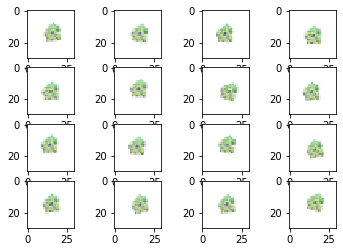

In [28]:
max_img_num = 16
imgs = []

X_sample = X_train[0]
# (height, width, 3) -> (1, height, width, 3)
X_sample = X_sample.reshape((1,) + X_sample.shape)

for d in datagen.flow(X_sample, batch_size=1):
    # このあと画像を表示するためにndarrayをPIL形式に変換して保存する
    imgs.append(keras_image.array_to_img(d[0], scale=True))
    # datagen.flowは無限ループするため必要な枚数取得できたらループを抜ける
    if (len(imgs) % max_img_num) == 0:
        break
show_imgs(imgs, row=4, col=4)

### 特徴空間にCNNを用いた回帰モデル定義

In [0]:
def model(X_shape, y_shape):
  model = Sequential()

  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=X_shape))
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(256))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))

  model.add(Dense(y_shape))
  
  optimizer = Adam()

  model.compile(loss='mse',
                optimizer=optimizer)
  return model

In [0]:
# patience は改善が見られるかを監視するエポック数を表すパラメーター
early_stop = EarlyStopping(monitor='val_loss', patience=10)

#### 合計種族値モデル

In [0]:
model_total = model(X_train.shape[1:4], 1)

history = model_total.fit_generator(datagen.flow(X_train, y_t_train, batch_size=32),
                    steps_per_epoch=len(y_t_train) / 32, epochs=200,
                    validation_data=(X_test, y_t_test), callbacks=[early_stop])

In [0]:
model_total.save('model_total.h5', include_optimizer=False)

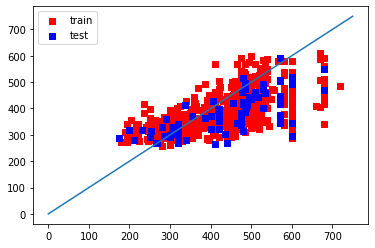

In [33]:
y_pred_train = model_total.predict(X_train)
y_pred_test = model_total.predict(X_test)

plt.scatter(y_t_train, y_pred_train, c='r', marker='s',label="train")
plt.scatter(y_t_test, y_pred_test, c='b', marker='s',label="test")
plt.legend()
plt.plot([0,750],[0,750])

#### HPモデル

In [0]:
model_hp = model(X_train.shape[1:4], 1)
history = model_hp.fit_generator(datagen.flow(X_train, y_h_train, batch_size=32),
                    steps_per_epoch=len(y_h_train) / 32, epochs=200,
                    validation_data=(X_test, y_h_test), callbacks=[early_stop])

In [0]:
model_hp.save('model_hp.h5', include_optimizer=False)

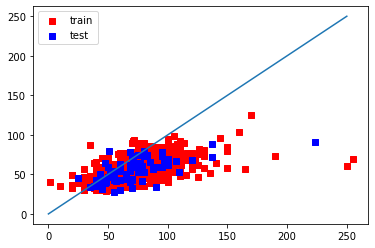

In [36]:
y_pred_train = model_hp.predict(X_train)
y_pred_test = model_hp.predict(X_test)

plt.scatter(y_h_train, y_pred_train, c='r', marker='s',label="train")
plt.scatter(y_h_test, y_pred_test, c='b', marker='s',label="test")
plt.legend()
plt.plot([0,250],[0,250])

#### Atackモデル

In [0]:
model_atack = model(X_train.shape[1:4], 1)
history = model_atack.fit_generator(datagen.flow(X_train, y_a_train, batch_size=32),
                    steps_per_epoch=len(y_a_train) / 32, epochs=200,
                    validation_data=(X_test, y_a_test), callbacks=[early_stop])

In [0]:
model_atack.save('model_atack.h5', include_optimizer=False)

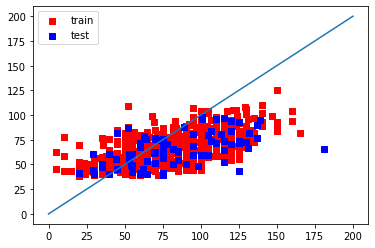

In [39]:
y_pred_train = model_atack.predict(X_train)
y_pred_test = model_atack.predict(X_test)

plt.scatter(y_a_train, y_pred_train, c='r', marker='s',label="train")
plt.scatter(y_a_test, y_pred_test, c='b', marker='s',label="test")
plt.legend()
plt.plot([0,200],[0,200])

#### Defenseモデル

In [0]:
model_defence = model(X_train.shape[1:4], 1)
history = model_defence.fit_generator(datagen.flow(X_train, y_b_train, batch_size=32),
                    steps_per_epoch=len(y_b_train) / 32, epochs=200,
                    validation_data=(X_test, y_b_test), callbacks=[early_stop])

In [0]:
model_defence.save('model_defence.h5', include_optimizer=False)

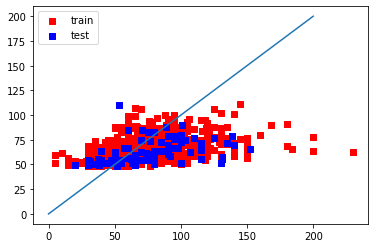

In [42]:
y_pred_train = model_defence.predict(X_train)
y_pred_test = model_defence.predict(X_test)

plt.scatter(y_b_train, y_pred_train, c='r', marker='s',label="train")
plt.scatter(y_b_test, y_pred_test, c='b', marker='s',label="test")
plt.legend()
plt.plot([0,200],[0,200])

#### SpAtackモデル

In [0]:
model_spatack = model(X_train.shape[1:4], 1)
history = model_spatack.fit_generator(datagen.flow(X_train, y_c_train, batch_size=32),
                    steps_per_epoch=len(y_c_train) / 32, epochs=200,
                    validation_data=(X_test, y_c_test), callbacks=[early_stop])

In [0]:
model_spatack.save('model_spatack.h5', include_optimizer=False)

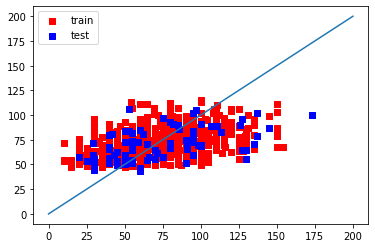

In [45]:
y_pred_train = model_spatack.predict(X_train)
y_pred_test = model_spatack.predict(X_test)

plt.scatter(y_c_train, y_pred_train, c='r', marker='s',label="train")
plt.scatter(y_c_test, y_pred_test, c='b', marker='s',label="test")
plt.legend()
plt.plot([0,200],[0,200])

#### SpDefence

In [0]:
model_spdefence = model(X_train.shape[1:4], 1)
history = model_spdefence.fit_generator(datagen.flow(X_train, y_d_train, batch_size=32),
                    steps_per_epoch=len(y_d_train) / 32, epochs=200,
                    validation_data=(X_test, y_d_test), callbacks=[early_stop])

In [0]:
model_spdefence.save('model_spdefence.h5', include_optimizer=False)

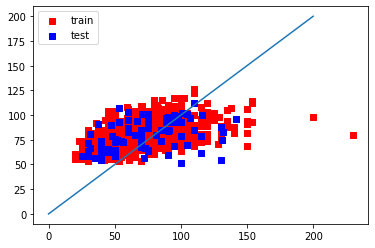

In [48]:
y_pred_train = model_spdefence.predict(X_train)
y_pred_test = model_spdefence.predict(X_test)

plt.scatter(y_d_train, y_pred_train, c='r', marker='s',label="train")
plt.scatter(y_d_test, y_pred_test, c='b', marker='s',label="test")
plt.legend()
plt.plot([0,200],[0,200])

#### Speedモデル

In [0]:
model_speed = model(X_train.shape[1:4], 1)
history = model_speed.fit_generator(datagen.flow(X_train, y_s_train, batch_size=32),
                    steps_per_epoch=len(y_s_train) / 32, epochs=200,
                    validation_data=(X_test, y_s_test), callbacks=[early_stop])

In [0]:
model_speed.save('model_speed.h5', include_optimizer=False)

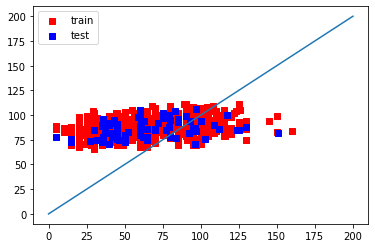

In [51]:
y_pred_train = model_speed.predict(X_train)
y_pred_test = model_speed.predict(X_test)

plt.scatter(y_s_train, y_pred_train, c='r', marker='s',label="train")
plt.scatter(y_s_test, y_pred_test, c='b', marker='s',label="test")
plt.legend()
plt.plot([0,200],[0,200])